In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, recall_score, precision_score, f1_score, matthews_corrcoef, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier


This dataset is part of the following publication, please cite when using this dataset: S. Matzka, "Explainable Artificial Intelligence for Predictive Maintenance Applications," 2020 Third International Conference on Artificial Intelligence for Industries (AI4I), 2020, pp. 69-74, doi: 10.1109/AI4I49448.2020.00023.

In [3]:
df = pd.read_csv("../data_sample/ai4i2020.csv")
df.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0


In [3]:
df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
UDI,10000.0,NaN,NaN,NaN,5000.5,2886.89568,1.0,2500.75,5000.5,7500.25,10000.0
Product ID,10000,10000,M14860,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Type,10000,3,L,6000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Air temperature [K],10000.0,NaN,NaN,NaN,300.00493,2.000259,295.3,298.3,300.1,301.5,304.5
Process temperature [K],10000.0,NaN,NaN,NaN,310.00556,1.483734,305.7,308.8,310.1,311.1,313.8
Rotational speed [rpm],10000.0,NaN,NaN,NaN,1538.7761,179.284096,1168.0,1423.0,1503.0,1612.0,2886.0
Torque [Nm],10000.0,NaN,NaN,NaN,39.98691,9.968934,3.8,33.2,40.1,46.8,76.6
Tool wear [min],10000.0,NaN,NaN,NaN,107.951,63.654147,0.0,53.0,108.0,162.0,253.0
Machine failure,10000.0,NaN,NaN,NaN,0.0339,0.180981,0.0,0.0,0.0,0.0,1.0
TWF,10000.0,NaN,NaN,NaN,0.0046,0.067671,0.0,0.0,0.0,0.0,1.0


# Preprocessing data
Here we remove the squared brackets of the variables names. Also, we handle invalid data to further calculations and plotting.

In [4]:
# Handling invalid data

df.columns = df.columns.str.replace('[', '').str.replace(']', '')
df.replace("?", np.nan, inplace=True)
for column in df.columns:
    try:
        df[column] = df[column].astype(float)
    except:
        pass
    
df_numeric = df.select_dtypes(include=[np.number])
df_numeric.replace([np.inf, -np.inf], np.nan, inplace=True)

df.head()


,UDI,Product ID,Type,Air temperature K,Process temperature K,Rotational speed rpm,Torque Nm,Tool wear min,Machine failure,TWF,HDF,PWF,OSF,RNF
0,1.0,M14860,M,298.1,308.6,1551.0,42.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2.0,L47181,L,298.2,308.7,1408.0,46.3,3.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3.0,L47182,L,298.1,308.5,1498.0,49.4,5.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4.0,L47183,L,298.2,308.6,1433.0,39.5,7.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5.0,L47184,L,298.2,308.7,1408.0,40.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0


# Exploratory Data Analysis EDA

In this section, we perform exploratory data analysis (EDA) to understand the distributions and relationships of the numerical features relevant to predicting machine failures. This involves visualizing the pairwise relationships between the features and their influence on machine failure occurrences.

### Numerical Features Analysis

The selected numerical features for this analysis include:
- Air temperature (K): Represents the ambient temperature during the operation of the machine.
- Process temperature (K): Indicates the temperature of the machine itself during the operation.
- Rotational speed (rpm): The speed at which the machine parts rotate.
- Torque (Nm): The amount of twisting force applied by the machine.
- Tool wear (min): The wear and tear of the machine tool, measured in minutes of operation.

We start by visualizing the pairwise relationships among these features using a pairplot. This visualization will help us identify patterns and correlations that could inform the machine failure predictions.

#### Correlation Heatmap

To further our analysis, we generate a heatmap of correlations among the numerical features. This heatmap helps us identify highly correlated features which may impact the predictability of machine failures. We apply a threshold to focus on correlations stronger than 0.80, highlighting significant relationships while filtering out less relevant ones.

#### Strong Correlations

Features that display strong correlations (above the 0.80 threshold) are particularly interesting as they might indicate redundancies or strong dependencies between operational parameters. The heatmap is color-coded from red (high positive correlation) to blue (high negative correlation), with annotations indicating the exact correlation values.

## Pairplot for Numerical Features

The pairplot includes the target variable 'Machine failure' to observe how these features interact under different failure conditions. We use different colors to distinguish between normal operation (blue) and failure states (orange).

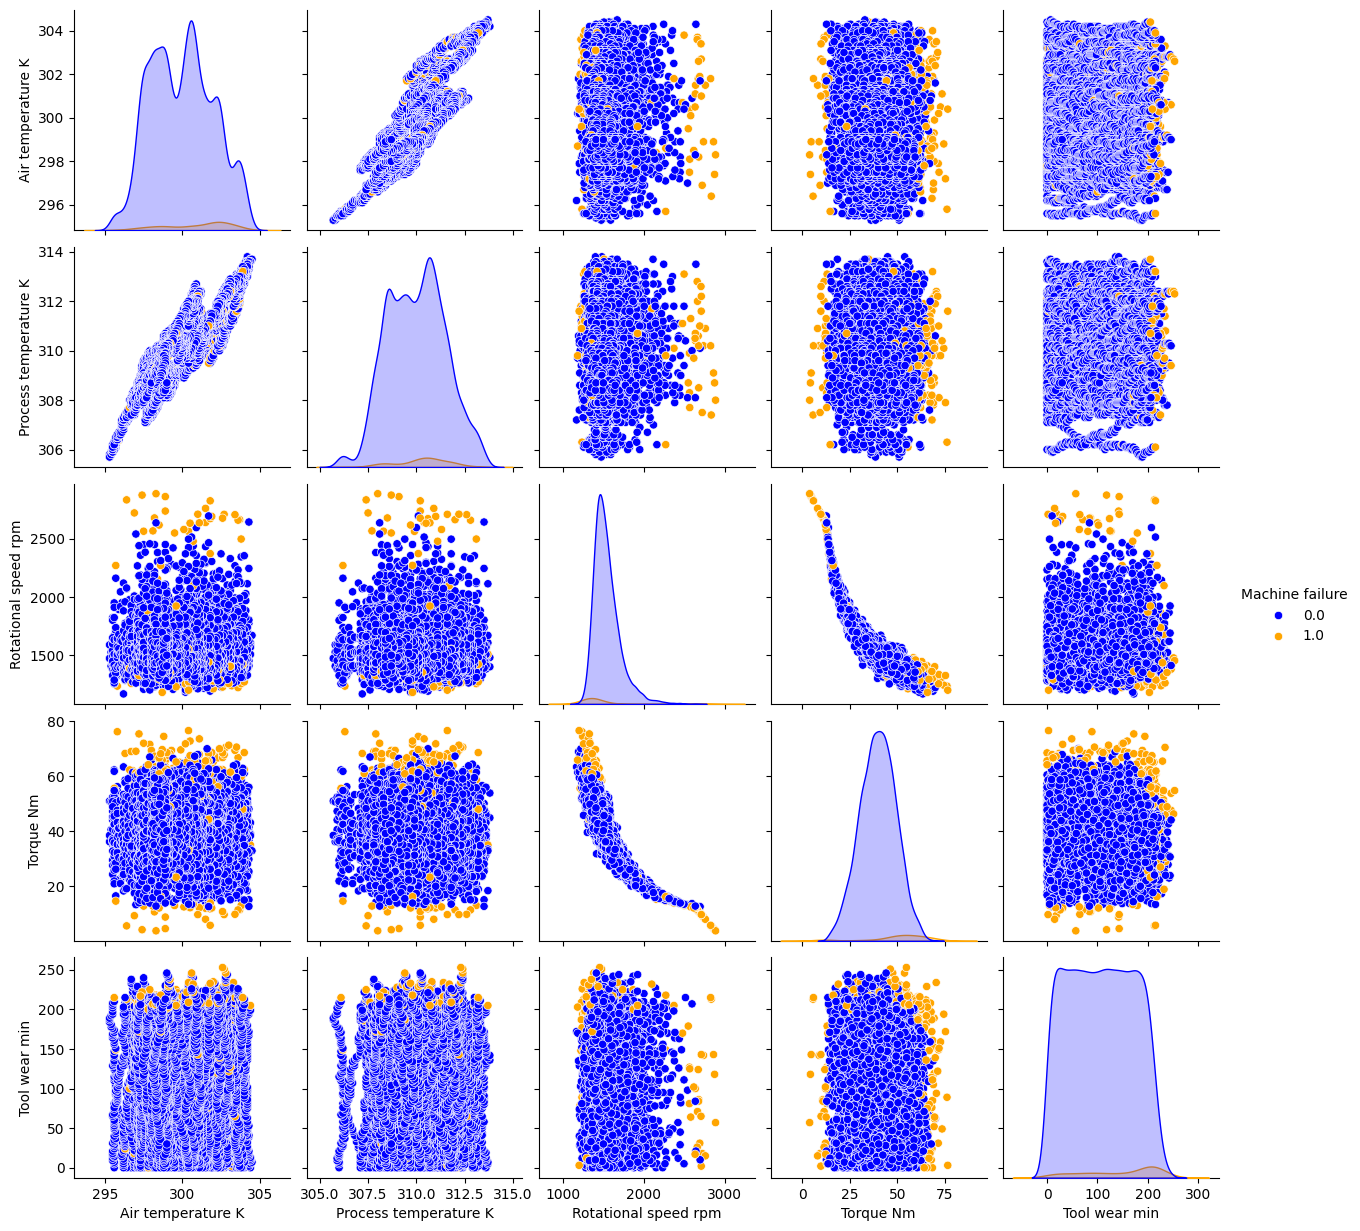

In [5]:
# List of numerical features to be analyzed, based on the dataset description 
numerical_features = [
    'Air temperature K', 
    'Process temperature K', 
    'Rotational speed rpm', 
    'Torque Nm', 
    'Tool wear min'
]

# Generating pairplot
sns.pairplot(df_numeric[numerical_features + ['Machine failure']], hue='Machine failure', palette={0: 'blue', 1: 'orange'})
plt.show()

## Correlation Heatmap

To further our analysis, we generate a heatmap of correlations among the numerical features. This heatmap helps us identify highly correlated features which may impact the predictability of machine failures. We apply a threshold to focus on correlations stronger than 0.80, highlighting significant relationships while filtering out less relevant ones.

#### Strong Correlations

Features that display strong correlations (above the 0.80 threshold) are particularly interesting as they might indicate redundancies or strong dependencies between operational parameters. The heatmap is color-coded from red (high positive correlation) to blue (high negative correlation), with annotations indicating the exact correlation values.


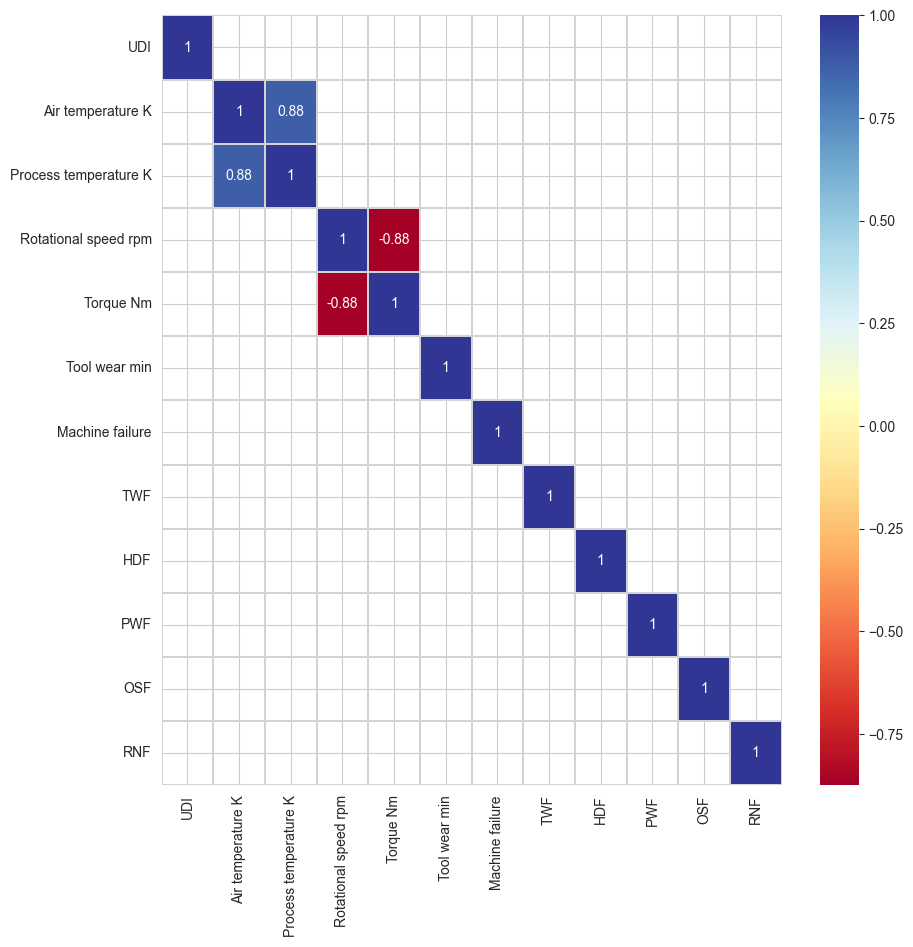

In [6]:
plt.figure(figsize=(10,10))
threshold = 0.80
sns.set_style("whitegrid", {"axes.facecolor": ".0"})
df_cluster2 = df_numeric.corr()
mask = df_cluster2.where((abs(df_cluster2) >= threshold)).isna()
plot_kws={"s": 1}
sns.heatmap(df_cluster2,
            cmap='RdYlBu',
            annot=True,
            mask=mask,
            linewidths=0.2, 
            linecolor='lightgrey').set_facecolor('white')

# Feature Engineering

We will create two new features that are expected to provide valuable insights into machine operations:
- **Torque_Rotational_speed**: This feature is a product of the torque and rotational speed. It represents the total mechanical power exerted by the machine, which may be a critical factor in predicting machine failures.
- **Temperature_difference**: This feature represents the difference between the process temperature and air temperature. A significant difference might indicate abnormal operating conditions.

### Cleaning and Formatting Data

Next, we perform the following cleaning steps:
- Drop unnecessary columns that are identifiers or are not useful for prediction, such as 'UDI', 'Product ID', and the individual failure modes.
- Convert categorical variables into dummy/indicator variables to make the dataset suitable for machine learning algorithms. This conversion is crucial for handling categorical data in models that require numerical input.
- Fill missing values with the mean of each column to avoid any bias that might arise from dropping rows or using another imputation method that could introduce noise.

In [7]:
df['Torque_Rotational_speed'] = df['Torque Nm'] * df['Rotational speed rpm']
df['Temperature_difference'] = df['Process temperature K'] - df['Air temperature K']

df.drop(['UDI','Product ID','TWF','HDF','PWF','OSF','RNF','Type'],axis=1,inplace=True)
list(df)

['Air temperature K',
 'Process temperature K',
 'Rotational speed rpm',
 'Torque Nm',
 'Tool wear min',
 'Machine failure',
 'Torque_Rotational_speed',
 'Temperature_difference']

In [8]:
df = pd.get_dummies(df,drop_first=True)

In [9]:
df_numeric.fillna(df_numeric.mean(), inplace=True)
for feature in df.columns:
    df[feature].fillna(df[feature].mean(), inplace=True)


C:\Users\joser\AppData\Local\Temp\ipykernel_29256\627787549.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[feature].fillna(df[feature].mean(), inplace=True)


In [10]:
df.describe(include='all').T

,count,mean,std,min,25%,50%,75%,max
Air temperature K,10000.0,300.00493,2.000259,295.3,298.3,300.1,301.50,304.5
Process temperature K,10000.0,310.00556,1.483734,305.7,308.8,310.1,311.10,313.8
Rotational speed rpm,10000.0,1538.77610,179.284096,1168.0,1423.0,1503.0,1612.00,2886.0
Torque Nm,10000.0,39.98691,9.968934,3.8,33.2,40.1,46.80,76.6
Tool wear min,10000.0,107.95100,63.654147,0.0,53.0,108.0,162.00,253.0
Machine failure,10000.0,0.03390,0.180981,0.0,0.0,0.0,0.00,1.0
Torque_Rotational_speed,10000.0,59967.14704,10193.093881,10966.8,53105.4,59883.9,66873.75,99980.4
Temperature_difference,10000.0,10.00063,1.001094,7.6,9.3,9.8,11.00,12.1


# Feature Selection

In this section, we use two different techniques to refine our feature set: univariate feature selection and backward stepwise regression. These methods help to reduce overfitting, improve model performance, and decrease computational complexity.

### Univariate Feature Selection

We use the `SelectKBest` method with the `chi2` statistic to perform univariate feature selection. This technique evaluates each feature individually to determine its strength of association with the response variable. Here, we select the best features based on the chi-squared test, which is particularly useful for categorical features.

The scores from this selection are visualized to show the importance of each feature. The features with higher scores are considered more relevant for predicting machine failure.

### Backward Stepwise Regression

After univariate selection, we apply backward stepwise regression. This method starts with all candidate features and iteratively removes the least significant feature (highest p-value) until all remaining features have a significant relationship with the target variable at the specified p-value threshold. This approach is based on p-values from OLS regression models and is effective in refining the feature set to include only those with strong statistical significance.


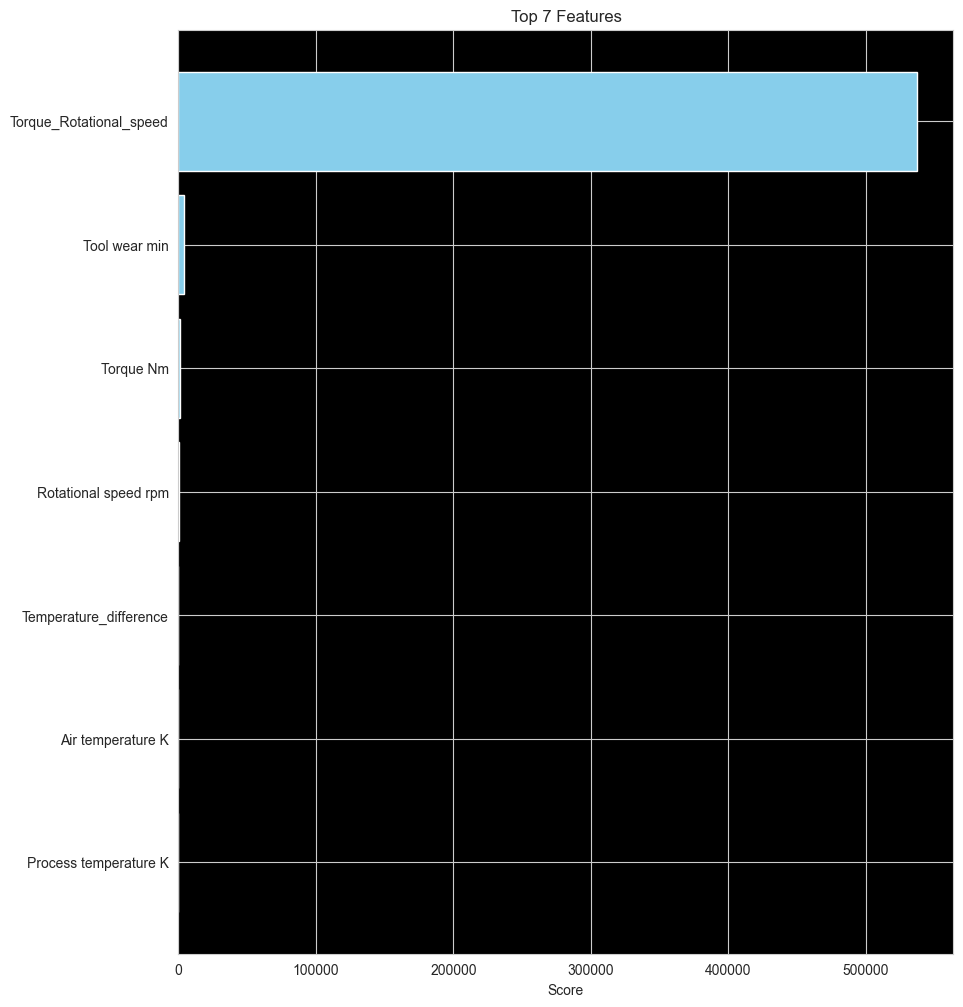

In [11]:
from sklearn.feature_selection import SelectKBest, chi2

best_features = SelectKBest(score_func=chi2,k='all')

y = df['Machine failure']  # For binary classification
X = df.drop(columns=['Machine failure'])
fit = best_features.fit(X, y)

df_scores = pd.DataFrame(fit.scores_)
df_col = pd.DataFrame(X.columns)

feature_score = pd.concat([df_col, df_scores], axis=1)
feature_score.columns = ['feature', 'score']
feature_score.sort_values(by=['score'], ascending=True, inplace=True)

# Plot using Matplotlib
plt.figure(figsize=(10, 12))
plt.barh(feature_score['feature'][0:21], feature_score['score'][0:21], color='skyblue')
plt.xlabel('Score')
plt.title('Top 7 Features')
plt.show()

In [12]:
import statsmodels.api as sm

Selected_Features = []

def backward_regression(X, y, initial_list=[], threshold_out=0.5, verbose=True):
    """To select feature with Backward Stepwise Regression 

    Args:
        X -- features values
        y -- target variable
        initial_list -- features header
        threshold_out -- pvalue threshold of features to drop
        verbose -- true to produce lots of logging output

    Returns:
        list of selected features for modeling 
    """
    included = list(X.columns)
    while True:
        changed = False
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max()  # null if pvalues is empty
        if worst_pval > threshold_out:
            changed = True
            worst_feature = pvalues.idxmax()
            included.remove(worst_feature)
            if verbose:
                print(f"worst_feature : {worst_feature}, {worst_pval} ")
        if not changed:
            break
    Selected_Features.append(included)
    print(f"\nSelected Features:\n{Selected_Features[0]}")


# Application of the backward regression function on our training data
backward_regression(X, y)


Selected Features:
['Air temperature K', 'Process temperature K', 'Rotational speed rpm', 'Torque Nm', 'Tool wear min', 'Torque_Rotational_speed', 'Temperature_difference']


Finally, we have the following features:

In [14]:
feature_names = list(X.columns)
np.shape(X)

(10000, 7)

# Modeling

With the feature selection completed, we proceed to train and evaluate a machine learning model. The primary goal is to predict machine failures accurately using the features identified as most predictive.

### Data Scaling

Data scaling is performed to normalize feature values so that no single feature dominates the model due to its scale. We use `MinMaxScaler` to transform each feature.

### Model Training

For the classification task, a `RandomForestClassifier` is used. This model is well-suited for handling complex datasets with interactions between features. It is trained using the scaled training data. I've tried `XGBoostClassifier` before, but I got better results with the current model.

### Threshold Adjustment

The prediction threshold was adjusted to optimize the balance between false positives and false negatives. This is particularly important in predictive maintenance, where the costs of false negatives might be high.

In [15]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

In [16]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [17]:
# Train the model with the best parameters
model = RandomForestClassifier()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

threshold = 0.44
y_pred_new = (y_pred_proba >= threshold).astype(int)


### Model Evaluation

After training, the model is evaluated using the testing set. Several metrics are computed to assess the model's performance:
- **Confusion Matrix**: Shows the number of correct and incorrect predictions, broken down by class.
- **Classification Report**: Includes precision, recall, F1-score, and support for each class.
- **ROC Curve and AUC Score**: The Receiver Operating Characteristic curve is plotted along with the Area Under the Curve (AUC) score to evaluate the model's ability to discriminate between classes.
- **Other Metrics**: Accuracy, recall, precision, F1-score, and Matthews correlation coefficient (MCC) provide additional insights into model performance.

Confusion Matrix:
[[1927    5]
 [  17   51]]
Classification Report:
              precision    recall  f1-score   support

         0.0     0.9913    0.9974    0.9943      1932
         1.0     0.9107    0.7500    0.8226        68

    accuracy                         0.9890      2000
   macro avg     0.9510    0.8737    0.9085      2000
weighted avg     0.9885    0.9890    0.9885      2000

ROC AUC Score: 95.98%
Accuracy: 98.90%
Recall: 98.90%
Precision: 98.85%
F1-Score: 98.85%
MCC: 82.11%


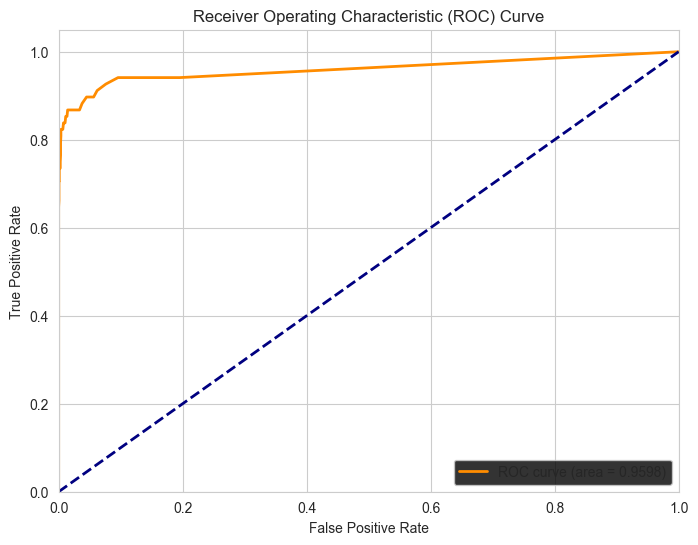

In [18]:
conf_matrix_new = confusion_matrix(y_test, y_pred_new)
class_report_new = classification_report(y_test, y_pred_new, digits=4)
roc_auc_new = roc_auc_score(y_test, y_pred_proba, average='weighted')
accuracy = accuracy_score(y_test, y_pred_new)
recall = recall_score(y_test, y_pred_new, average='weighted')
precision = precision_score(y_test, y_pred_new, average='weighted')
f1s = f1_score(y_test, y_pred_new, average='weighted')
mcc = matthews_corrcoef(y_test, y_pred_new)

# Print metrics
print(f"Confusion Matrix:\n{conf_matrix_new}")
print(f"Classification Report:\n{class_report_new}")
print(f"ROC AUC Score: {roc_auc_new:.2%}")
print(f"Accuracy: {accuracy:.2%}")
print(f"Recall: {recall:.2%}")
print(f"Precision: {precision:.2%}")
print(f"F1-Score: {f1s:.2%}")
print(f"MCC: {mcc:.2%}")

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6), facecolor='white')
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.gca().set_facecolor('white')
plt.show()